## Imports

In [1]:
# utils
import os
import sys
from pathlib import Path

PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# viz
import matplotlib.pyplot as plt

# basics
import numpy as np
import pandas as pd

# metrics
from tqdm import tqdm

# metrics
from utils import config
from utils.reader import read_file_yaml
from utils.utils import get_last_modification_directory
import warnings

warnings.filterwarnings("ignore")

## Parameters

In [2]:
path_outputs = PROJECT_DIR / "outputs"
path_data_url = PROJECT_DIR / "data"
file_path_parameters = PROJECT_DIR / "conf" / "parameters.yml"
parameters = read_file_yaml(file_path_parameters)
path_results = PROJECT_DIR / parameters["results"]["filepath"]
path_results_url = PROJECT_DIR / parameters["results"]["filepath"]
ext_type = parameters["outputs"]["extension_type"]
ext_local_img = parameters["outputs"]["extension_local_img"]
ext_best_img = parameters["outputs"]["extension_best_img"]

n_random = np.sort(
    [int(i.replace("random_n", "")) for i in os.listdir(path_results_url) if ".placehold" not in i]
)
path_random = ["random_n" + str(i) for i in n_random]
path_results = [path_results_url / i for i in path_random]

_, path_random = get_last_modification_directory(path_results, path_random, parameters)

file_path_abi_diff = {
    i_name: {
        name: {
            _param: i / name / "params" / Path(_param + ext_type)
            for _param in ["abilities", "diff_disc"]
        }
        for name in config.file_names
    }
    for i, i_name in zip(path_results, path_random)
}

file_path_pij = {
    i_name: {
        name: {_param: i / name / "pij" / Path(_param + ext_type) for _param in ["pij_true", "pij_pred"]}
        for name in config.file_names
    }
    for i, i_name in zip(path_results, path_random)
}

## Read datasets

In [3]:
# params
data_params = {
    i_random: {
        j_name: {k_param: pd.read_csv(k_content, index_col=0) for k_param, k_content in j_content.items()}
        for j_name, j_content in i_content.items()
    }
    for i_random, i_content in file_path_abi_diff.items()
}

In [4]:
# pij
data_pij = {
    i_random: {
        j_name: {k_param: pd.read_csv(k_content, index_col=0) for k_param, k_content in j_content.items()}
        for j_name, j_content in i_content.items()
    }
    for i_random, i_content in file_path_pij.items()
}

## Unique plot

In [139]:
markers = [".", "o", "v", "^", "1", "2", "s", "p", "P"]
figs_unique = {}
xy_fontsize = 26
for i_random in tqdm(path_random[:1]):
    figs_unique[i_random] = {}
    _fig_abi, _axes_abi = plt.subplots(1, 1, figsize=(10, 8), **parameters["outputs"]["args"])
    _fig_diff, _axes_diff = plt.subplots(1, 1, figsize=(10, 8), **parameters["outputs"]["args"])
    abi_concat = pd.DataFrame(columns = ["index", "avg_response", "abilities"])
    for idx, (i_name, i_content) in enumerate(list(data_pij[i_random].items())):    
        pij_true = i_content["pij_true"].copy()
        abilities = data_params[i_random][i_name]["abilities"]
        diffs = data_params[i_random][i_name]["diff_disc"]
        
        response = (
            pij_true
            .T
            .mean(axis = 1)
            .to_frame("avg_response")
            .reset_index()
            .merge(abilities.reset_index(), on = ["index"])
        )
        abi_concat = pd.concat([abi_concat, response], ignore_index = True)
        response_models = (
            response[~response["index"].str.startswith("random_model_n")].copy()
        )
        response_random = (
            response[response["index"].str.startswith("random_model_n")].copy()
        )
        _params_plot = [
            {
                "x": _param[0],
                "y": _param[1],
                "marker": markers[idx]
                #"c": "#1f77b4"
            }
            for _param in [
                [response_models["avg_response"].values, response_models["abilities"].values],
                [pij_true.mean(axis=1).values, diffs["difficulty"].values],
            ]
        ]
        
        for idx_param, _param in enumerate(_params_plot):
            if idx_param == 1:
                # _param = _param | {"c": diffs["discrimination"].values}
                _axes_diff.set_xlabel("average item response", fontsize=xy_fontsize)
                _axes_diff.set_ylabel("difficulties", fontsize=xy_fontsize)
                scatter = _axes_diff.scatter(label = i_name.title().replace("_"," "), **_param)
                # cbar = plt.colorbar(scatter, ax=_axes_diff)
                # cbar.set_label("discrimination")
                # _axes_diff.set_title(
                #     r"$\rho = $" + " {:.5}".format(np.corrcoef(_param["x"], _param["y"])[0, 1]), 
                #     loc="center",
                #     fontsize = xy_fontsize+2
                # )
                _axes_diff.legend(loc = 'upper right', fontsize=16)
            else:
                _axes_abi.set_xlabel("average model response", fontsize=xy_fontsize)
                _axes_abi.set_ylabel("abilities", fontsize=xy_fontsize)
                
                if i_random != "random_n0":
                    _param.update({"label": "models"})
                else:
                    scatter = _axes_abi.scatter(label = i_name.title().replace("_"," "), **_param)
                    _axes_abi.legend(loc = 'lower right', fontsize=16)
                if i_random != "random_n0":
                    _axes_abi.scatter(
                        x = response_random["avg_response"].values,
                        y = response_random["abilities"].values,
                        c = "red",
                        label = r"$p = {}$".format(len(response_random["avg_response"].values))
                    )
                    _axes_abi.legend(fontsize=26)

            _axes_abi.grid(True)
            _axes_diff.grid(True)
            
        _fig_abi.tight_layout()
        _fig_diff.tight_layout()
        # _axes_abi.set_title(
        #             r"$\rho = $" + " {:.5}".format(np.corrcoef(abi_concat["avg_response"], abi_concat["abilities"])[0, 1]), 
        #             loc="center",
        #             fontsize = xy_fontsize+2
        #         )
        plt.close()
    del abi_concat
    figs_unique[i_random] = {
            "abilities": {
                "figure": _fig_abi,
                "file_path": (
                    path_outputs / Path("_".join([i_random, "abi", "versus","all"]) + ext_local_img)
                )
            },
            "difficulties": {
                "figure": _fig_diff,
                "file_path": (
                    path_outputs / Path("_".join([i_random, "diff", "versus","all"]) + ext_local_img)
                )
            }
        }

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


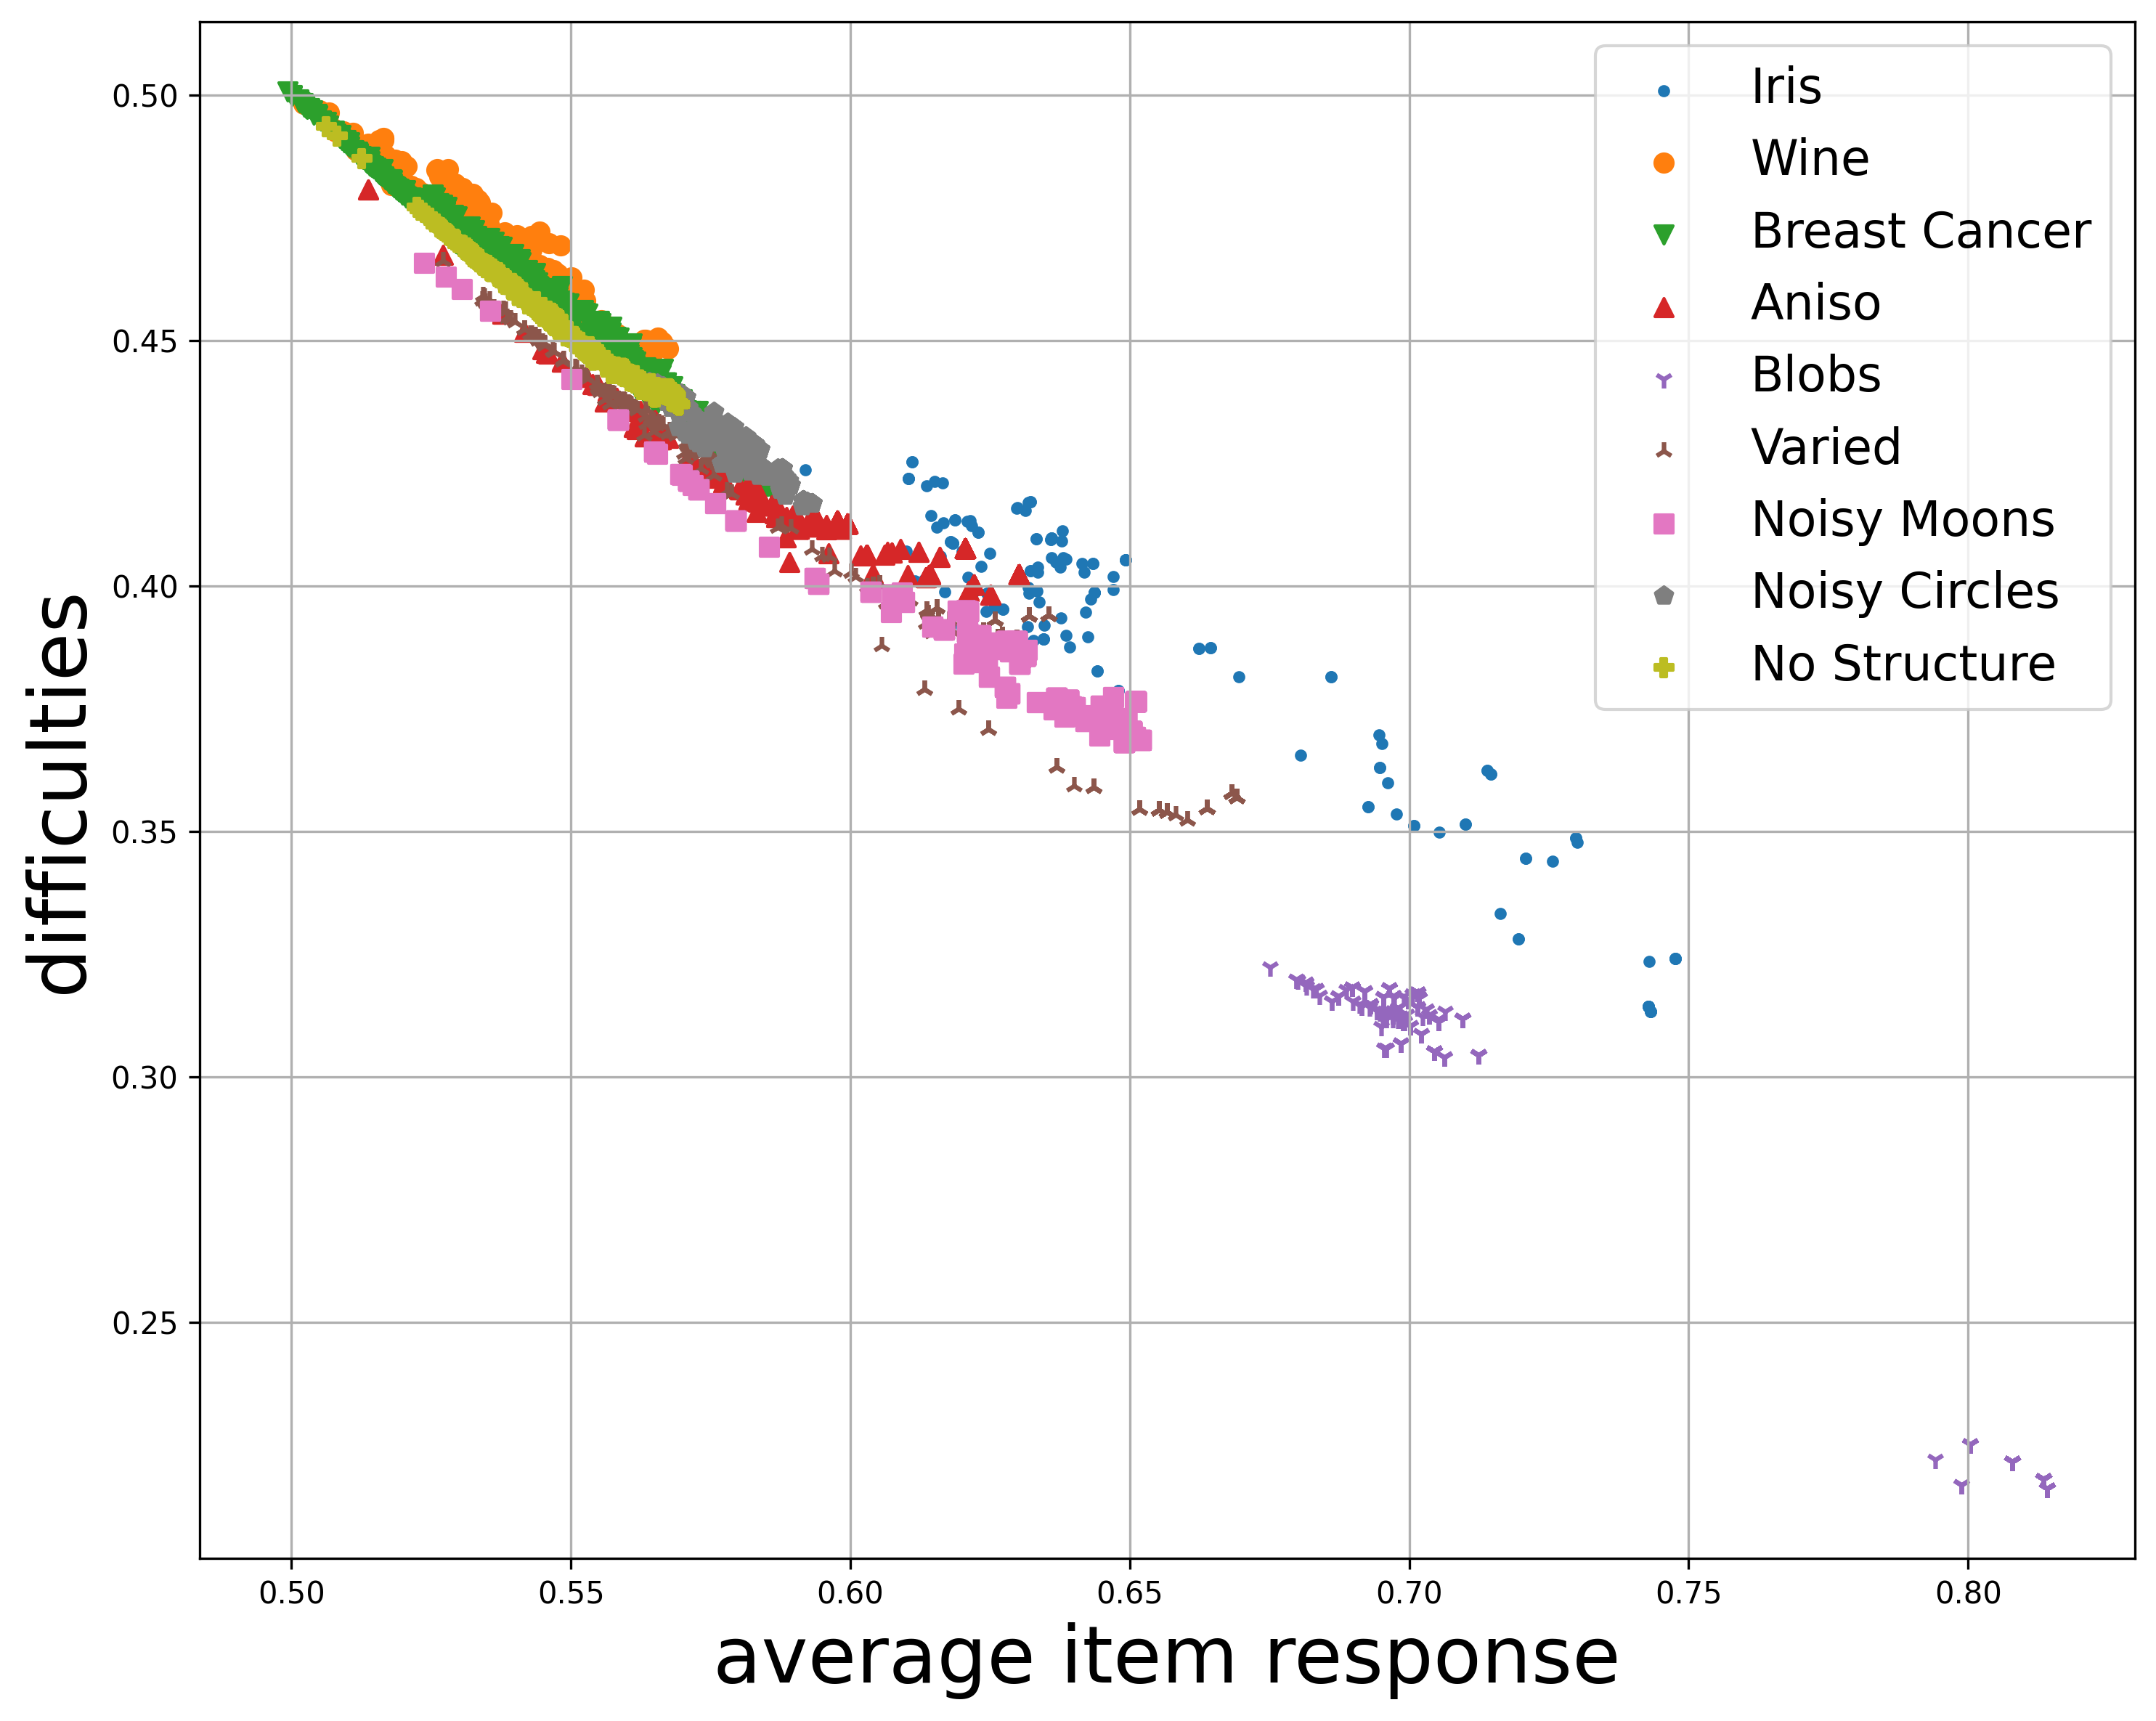

In [141]:
# figs_unique["random_n0"]["difficulties"]["figure"]

## Save

In [143]:
for i_random, i_content in tqdm(list(figs_unique.items())):
    for which_param, contents in i_content.items():
        _fig, _file_path = contents["figure"], contents["file_path"]
        _fig.savefig(_file_path, **parameters["outputs"]["args"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]
